# ARIMA Process Dataset

This script constructs a synthetic dataset using the ARIMA (Autoregressive Integrated Moving Average) model, which is held in high regard across various domains for its aptitude in modeling and predicting temporal patterns in data.

The dataset consists of specific ARIMA scenarios, each focusing on isolating different components to allow an understanding of their individual effects:

1. **Pure Noise:**

   - **Pure noise:** This is a pure random noise series, with no AR, MA, or differencing components. This series serves as a benchmark, showcasing a time series devoid of any discernible temporal structure. This series is labeled `series_0` in the data.

2. **Autoregressive (AR) Components:** Ten series are crafted to highlight the influences of specific AR lags, ranging from AR(1) to AR(10). These series are labeled `series 1`, `series_2`, ..., `series_10` in the data. Specifically:

   - **AR(1):** Incorporates the AR term of the order 1.
   - **AR(2):** Includes the AR term corresponding to the lag 2, without the influence of lag 1.
   - **...**
   - **AR(10):** Focuses on the AR term associated with the lag 10.

   These series have MA components and differencing set to zero, strictly focusing on the AR behaviors.

3. **Moving Average (MA) Components:** Another set of ten series (labeled `series_11` through `series_20`), these spotlight the effects of MA components, capturing the influence of past white noise or shock terms. The setup is similar to the AR set, progressing from **MA(1)**, **MA(2)**, to **MA(10)**.

4. **Integration (I) for Differencing:** The series in this category were constructed using inverse differencing, implying that to render them stationary, they would need to be differenced. These series do not have AR or MA components:

   - **I(1):** Inverse-differenced once; titled `series_21`
   - **I(2):** Inverse-differenced twice; titled `series_22`
   - **I(3):** Inverse-differenced three times; titled `series_23`

5. **ARIMA Scenario:**

   - **ARIMA (hybrid):** A mix of AR, MA terms, and differencing, encapsulating the multifaceted nature of many real-world time series. This series contains three AR terms (AR2, AR7, AR9), two MA terms - MA3, MA5, and differencing 1 time. This series is labeled `series_24` in the data.

Dataset Columns:

- **series_id:** A unique identifier for each series, formatted as "series_X" where X represents the series number.
- **time_step:** A chronological marker within the series.
- **value:** Denotes the actual value at a specific time point.

**Applications**:
This dataset offers an invaluable toolkit for understanding and modeling time series data, suitable for tasks like model validation, analyzing component impacts, and establishing benchmark standards.


In [27]:
import numpy as np
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import sys

In [28]:
import warnings

# Suppress specific warnings from statsmodels
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)    

In [29]:
dataset_name = "arima_process"

In [30]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Functions for Data Generation

In [31]:
def inverse_difference(y: np.ndarray) -> np.ndarray:
    """
    Inverse difference a time series once.
    
    Args:
        y (np.ndarray): Input time series that needs to be inverse differenced.
    
    Returns:
        np.ndarray: Inverse differenced time series.
    """
    y_inv_diff = np.zeros_like(y)
    y_inv_diff[0] = y[0]
    
    for i in range(1, len(y)):
        y_inv_diff[i] = y[i] + y_inv_diff[i-1]
    
    return y_inv_diff

In [32]:
def generate_arima_series(ar: list, ma: list, n_samples: int, noise_std: float = 0.0) -> np.ndarray:
    """
    Generate a time series sample from an ARMA process with an optional addition of Gaussian noise.

    Parameters:
    - ar (list): List of autoregressive coefficients. For an AR(p) model, this list should have 'p' elements.
    - ma (list): List of moving average coefficients. For an MA(q) model, this list should have 'q' elements.
    - n_samples (int): The number of time series data points to generate.
    - noise_std (float, optional): Standard deviation of Gaussian noise added to the series. Defaults to 0.0, implying no noise.

    Returns:
    - np.ndarray: Generated time series of shape `(n_samples,)` following the specified ARMA process with added noise.

    Note:
    This function assumes the ARMA process to be stationary and invertible for the given AR and MA coefficients.
    """    
    # Initialize the ARMA process
    arma_process = sm.tsa.ArmaProcess(np.r_[1, -np.array(ar)], np.r_[1, np.array(ma)])

    # Generate a sample from ARMA process
    y = arma_process.generate_sample(nsample=n_samples)

    # Add Gaussian noise
    y += np.random.normal(loc=0, scale=noise_std, size=n_samples)

    return y

In [33]:
def generate_data(series_len=500, noise_std=0.5):
    """
    Generate a dataset consisting of various ARIMA series.

    This function produces a collection of time series datasets to represent different ARIMA processes.
    The generated series include pure noise, AR, MA, differenced series (to indicate integration), and a combined ARIMA series.

    Parameters:
    - series_len (int, optional): Length of each generated series. Defaults to 500.
    - noise_std (float, optional): Standard deviation of noise for the pure noise series. Defaults to 0.5.

    Returns:
    - pd.DataFrame: A DataFrame with columns: "series_id", "time_step", and "value". Each unique `series_id` corresponds
                    to a distinct time series dataset generated based on a specific ARIMA process.

    Notes:
    - series_id = 0: Represents a pure noise series.
    - series_id = 1 to 10: Represents AR processes with different lags.
    - series_id = 11 to 20: Represents MA processes with different lags.
    - series_id = 21 to 23: Represents series that are inverse-differenced multiple times.
    - series_id = 24: Represents a combined ARIMA process.

    Examples:
    >>> df = generate_data()
    >>> print(df[df["series_id"] == 0].head())  # This should show the first few rows of the pure noise series.
    """
    series_data = []
    series_id = 0
    
    # 0. Noise Dataset
    noise_series = np.random.normal(loc=0, scale=noise_std, size=series_len)
    series_data.extend(store_series_data(noise_series, series_id))
    series_id += 1
    
    # 1. AR Datasets
    for i in range(1, 11):
        ar = [1 if j == i else 0 for j in range(1, 11)]
        ma = [0] * 10
        y = generate_arima_series(ar, ma, series_len)
        series_data.extend(store_series_data(y, series_id))
        series_id += 1

    # 2. MA Datasets
    for i in range(1, 11):
        ma = [1 if j == i else 0 for j in range(1, 11)]
        ar = [0] * 10
        y = generate_arima_series(ar, ma, series_len)
        series_data.extend(store_series_data(y, series_id))
        series_id += 1

    # 3. Differencing ("I") Datasets
    for i in range(1, 4):
        ar = [0] * 10
        ma = [0] * 10
        y = generate_arima_series(ar, ma, series_len)
        for _ in range(i):
            y = inverse_difference(y)
        series_data.extend(store_series_data(y, series_id))
        series_id += 1
    
    # 4. ARIMA Dataset
    ar = [0.2 if i in [2, 7, 9] else 0 for i in range(1, 11)]
    ma = [0.2 if i in [3, 5] else 0 for i in range(1, 11)]
    y = generate_arima_series(ar, ma, series_len)
    y = inverse_difference(y)
    series_data.extend(store_series_data(y, series_id))
    
    df = pd.DataFrame(series_data, columns=["series_id", "time_step", "value"])
    return df


def store_series_data(y: np.ndarray, series_id: int) -> list[tuple[str, int, float]]:
    """
    Convert a time series into a structured list for storage.

    Given a time series array and its identifier, this function structures the data 
    into a list of tuples, where each tuple contains the series identifier, the time step, 
    and the corresponding value of the series at that time step.

    Parameters:
    - y (np.ndarray): The time series data to be structured.
    - series_id (int): The identifier for the given time series.

    Returns:
    - list[tuple[str, int, float]]: A list of tuples with each tuple structured as ("series_X", time_step, value), 
                                    where X is the series_id.

    Example:
    >>> y = [1, 2, 3, 4]
    >>> series_id = 1
    >>> store_series_data(y, series_id)
    [('series_1', 1, 1), ('series_1', 2, 2), ('series_1', 3, 3), ('series_1', 4, 4)]
    """

    data = []
    for time_step, value in enumerate(y, start=1):
        data.append((f"series_{series_id}", time_step, value))
    return data


# Generate Dataset

In [34]:
np.random.seed(5)

# Generate the data
data = generate_data(series_len=750)
print(data.shape)

(18750, 3)


In [35]:
# round the value column 
data['value'] = data['value'].round(3)

In [36]:
data.head()

,series_id,time_step,value
0,series_0,1,0.221
1,series_0,2,-0.165
2,series_0,3,1.215
3,series_0,4,-0.126
4,series_0,5,0.055


In [37]:
series_col = "series_id"
epoch_col = 'time_step'
time_col = None
value_col = 'value'
exog_cols=[]

# Verify Datasets are Correctly Generated

In [38]:
def validate_series(y: ndarray, p: int, d: int, q: int) -> None:
    """
    Validate the given time series using an ARIMA model. The function fits an ARIMA(p,d,q) model
    to the series, displays the model summary, plots the ACF and PACF of the residuals,
    and performs the Augmented Dickey-Fuller test.

    Args:
        y (ndarray): Time series data to be validated.
        p (int): The autoregressive order of the ARIMA model.
        d (int): The differencing order of the ARIMA model.
        q (int): The moving average order of the ARIMA model.

    Returns:
        None: The function displays plots and prints results but does not return any values.
    """
    # Fit ARIMA model
    model: ARIMAResults = sm.tsa.ARIMA(y, order=(p, d, q)).fit()
    
    print(model.summary())

    # Residuals
    residuals: ndarray = model.resid

    # ACF and PACF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1])
    
    plt.tight_layout()
    plt.show()

    # ADF test
    adf_result = sm.tsa.adfuller(y)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                ARIMA(10, 0, 0)   Log Likelihood               -1073.094
Date:                Sun, 12 Nov 2023   AIC                           2170.188
Time:                        11:11:10   BIC                           2225.629
Sample:                             0   HQIC                          2191.550
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4386     25.350      1.437      0.151     -13.246      86.123
ar.L1          0.9991      0.038     25.977      0.000       0.924       1.074
ar.L2         -0.0152      0.051     -0.296      0.7

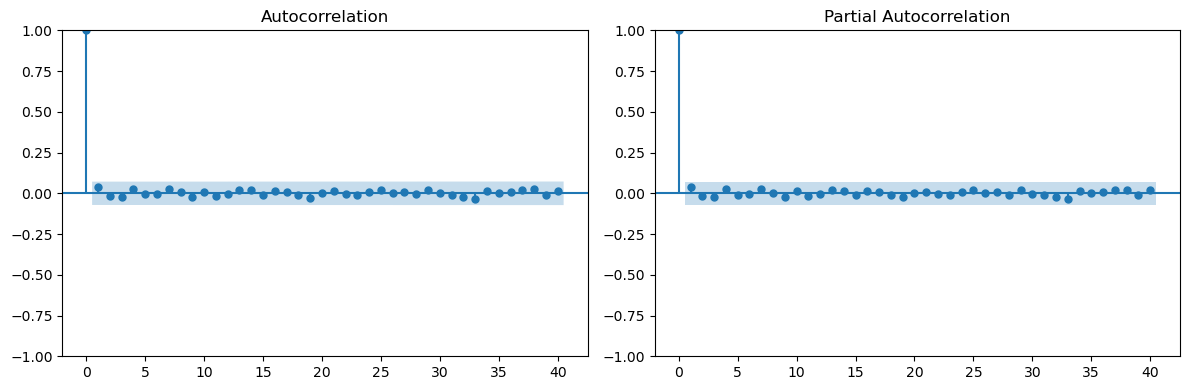

ADF Statistic: -1.60094384962796
p-value: 0.4831193247817075
Critical Values: {'1%': -3.439110818166223, '5%': -2.8654065210185795, '10%': -2.568828945705979}


In [39]:
# AR1 model 
series_id = "series_1" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 10, 0, 0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                ARIMA(10, 0, 0)   Log Likelihood               -1046.056
Date:                Sun, 12 Nov 2023   AIC                           2116.112
Time:                        11:11:13   BIC                           2171.553
Sample:                             0   HQIC                          2137.474
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0528      2.813      0.019      0.985      -5.460       5.565
ar.L1         -0.0068      0.037     -0.184      0.854      -0.079       0.065
ar.L2         -0.0578      0.036     -1.605      0.1

C:\Users\abbus\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


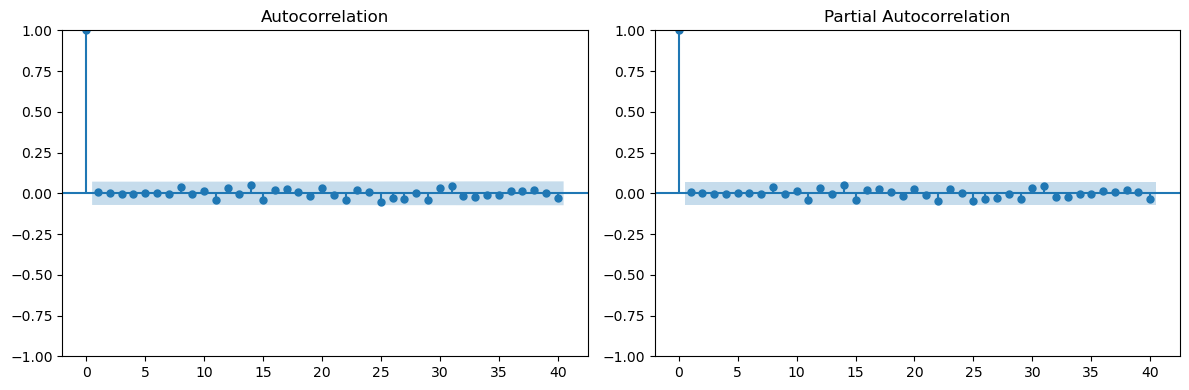

ADF Statistic: -1.0852089648203056
p-value: 0.7209342122552865
Critical Values: {'1%': -3.4391580196774494, '5%': -2.8654273226340554, '10%': -2.5688400274762397}


In [40]:
# AR5 model 
series_id = "series_5" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 10, 0, 0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                ARIMA(0, 0, 10)   Log Likelihood               -1088.254
Date:                Sun, 12 Nov 2023   AIC                           2200.507
Time:                        11:11:13   BIC                           2255.948
Sample:                             0   HQIC                          2221.870
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0142      0.074     -0.193      0.847      -0.158       0.130
ma.L1          1.0242      0.037     27.774      0.000       0.952       1.096
ma.L2          0.0679      0.055      1.241      0.2

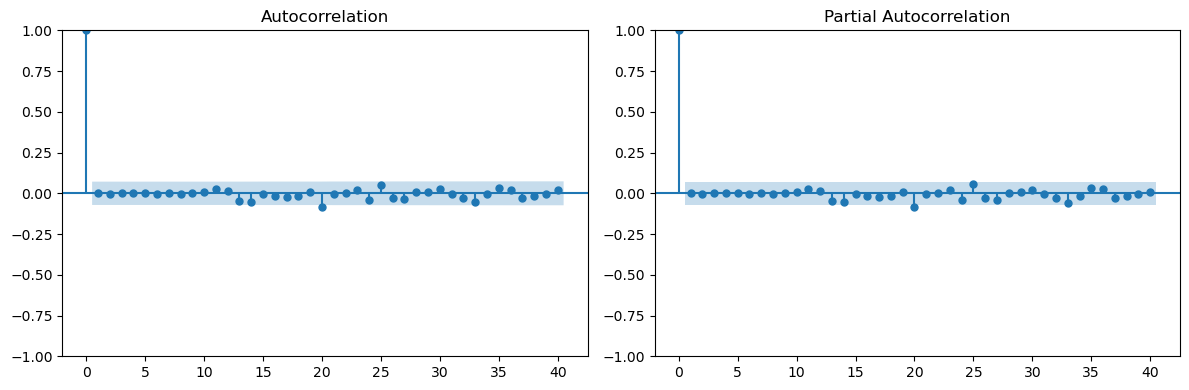

ADF Statistic: -7.304664626810871
p-value: 1.3110315726042828e-10
Critical Values: {'1%': -3.439290485895927, '5%': -2.8654856985173414, '10%': -2.568871126669587}


In [41]:
# MA1 model 
series_id = "series_11" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 0, 0, 10)

C:\Users\abbus\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                ARIMA(0, 0, 10)   Log Likelihood               -1079.988
Date:                Sun, 12 Nov 2023   AIC                           2183.976
Time:                        11:11:15   BIC                           2239.416
Sample:                             0   HQIC                          2205.338
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0594      0.067      0.883      0.377      -0.072       0.191
ma.L1         -0.0268      0.160     -0.168      0.867      -0.340       0.286
ma.L2         -0.0542      0.198     -0.273      0.7

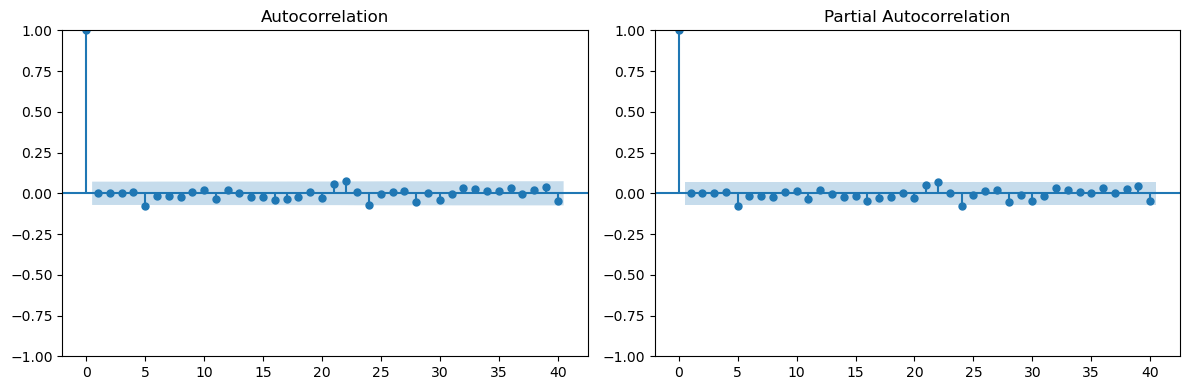

ADF Statistic: -5.399303560864576
p-value: 3.398631075212373e-06
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [42]:
# MA7 model 
series_id = "series_17" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 0, 0, 10)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1049.880
Date:                Sun, 12 Nov 2023   AIC                           2101.760
Time:                        11:11:15   BIC                           2106.379
Sample:                             0   HQIC                          2103.540
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9661      0.048     20.046      0.000       0.872       1.061
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 6.56
Prob(Q):                              0.30   Pr

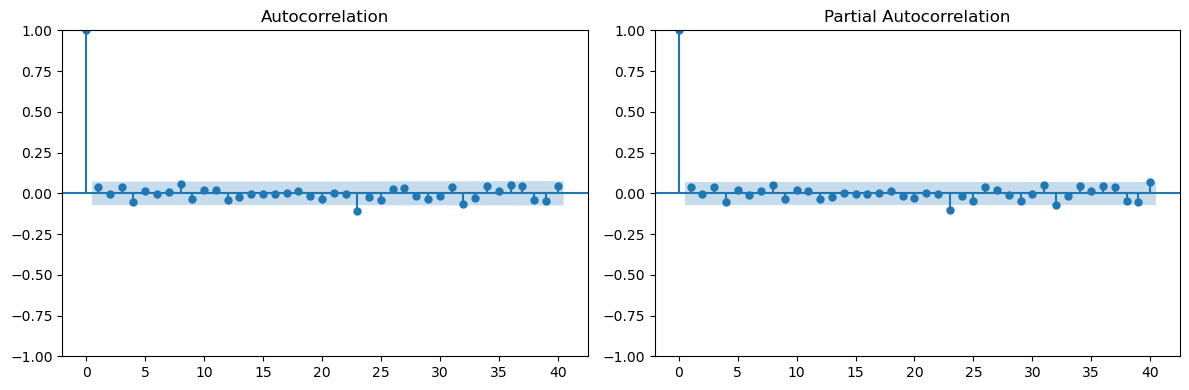

ADF Statistic: -0.6599404740003804
p-value: 0.856854851209447
Critical Values: {'1%': -3.439110818166223, '5%': -2.8654065210185795, '10%': -2.568828945705979}


In [43]:
# I1 model 
series_id = "series_21" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 0, 1, 0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                 ARIMA(0, 3, 0)   Log Likelihood               -1056.041
Date:                Sun, 12 Nov 2023   AIC                           2114.082
Time:                        11:11:15   BIC                           2118.698
Sample:                             0   HQIC                          2115.861
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9896      0.052     18.932      0.000       0.887       1.092
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.33   Pr

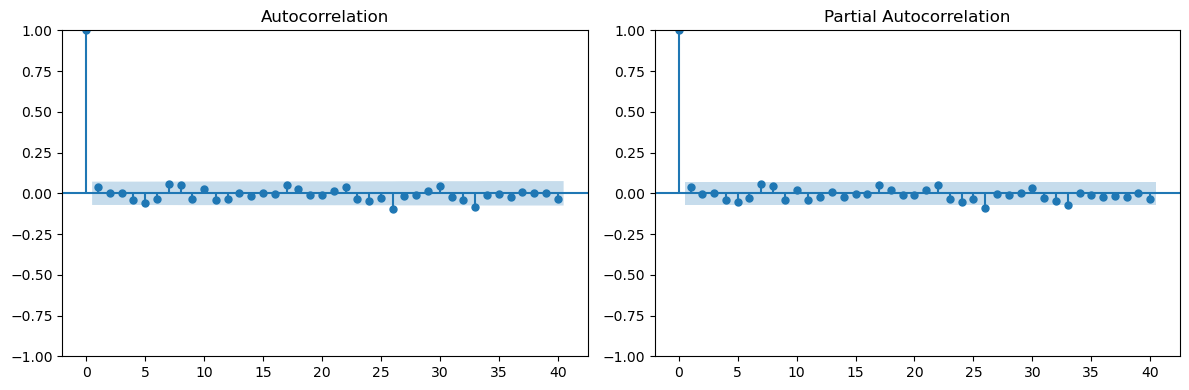

ADF Statistic: 1.435374193727595
p-value: 0.9972690629091312
Critical Values: {'1%': -3.439134355513998, '5%': -2.865416893922985, '10%': -2.56883447171999}


In [44]:
# I3 model 
series_id = "series_23" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 0, 3, 0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  750
Model:                 ARIMA(9, 1, 5)   Log Likelihood               -1035.926
Date:                Sun, 12 Nov 2023   AIC                           2101.853
Time:                        11:11:17   BIC                           2171.134
Sample:                             0   HQIC                          2128.550
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1119      0.167      0.669      0.503      -0.216       0.439
ar.L2          0.1778      0.168      1.060      0.289      -0.151       0.507
ar.L3         -0.3404      0.128     -2.656      0.0

C:\Users\abbus\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


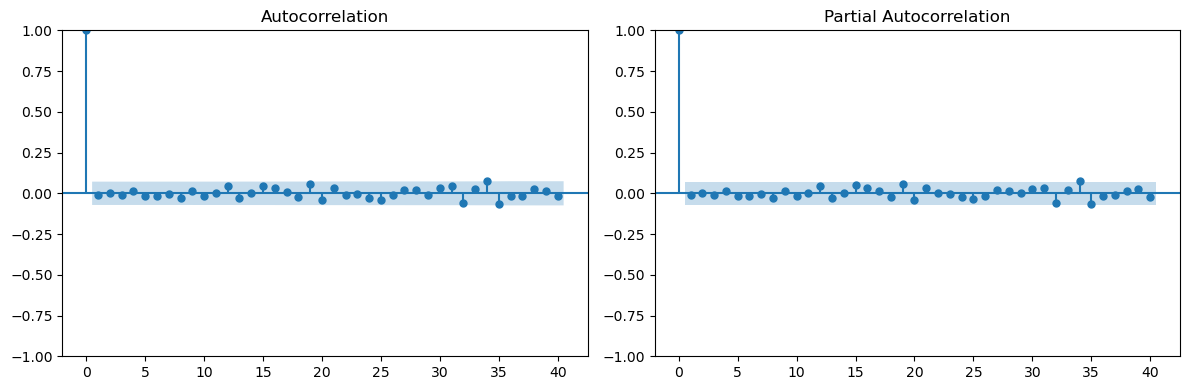

ADF Statistic: -1.1862569835134025
p-value: 0.6794794954784025
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [45]:
# ARIMA model 
series_id = "series_24" 
y = data[data['series_id'] == series_id]['value'].values
validate_series(y, 9, 1, 5)

# Visualize Data

In [46]:
def visualize_series(df: pd.DataFrame, series_to_visualize: list, filename: str=None, ) -> None:
    """
    Visualizes the series in the provided DataFrame using subplots and saves the plot as a PNG file.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the series data with columns series_id, t, and y.
    - series_to_visualize (List(str)): List of series ids to visualize
    - filename (str): Name of the file to save the plot.
    
    Returns:
    - None
    """
    t = df['time_step'].unique()
    unique_series = sorted(df['series_id'].unique())
    
    fig, axes = plt.subplots(nrows=len(series_to_visualize), ncols=1, figsize=(6, 8), sharex=True)

    for i, series_id in enumerate(series_to_visualize):
        y = df[df['series_id'] == series_id]['value'].values[:100]
        axes[i].plot(t[:100], y, label=series_id, color="blue")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel("Time")
    fig.suptitle("Synthetic ARIMA Dataset", y=0.98)
    plt.tight_layout()
    
    # Save the figure
    if filename is not None:
        plt.savefig(filename)
    # Display the plot in Jupyter Notebook
    # plt.show()

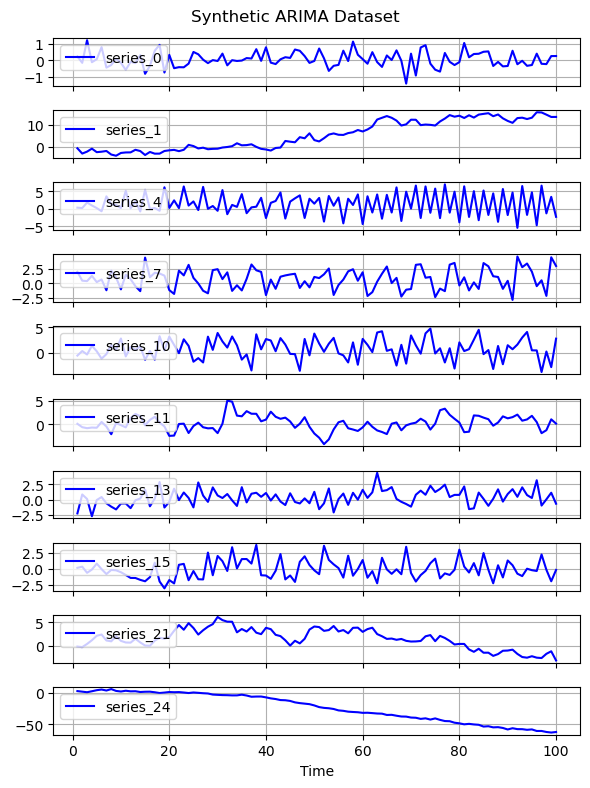

In [47]:
# Visualize the data
series_to_visualize = [
    'series_0', 
    'series_1', 'series_4', 'series_7', 'series_10',
    'series_11', 'series_13', 'series_15',
    'series_21',
    'series_24'
]
visualize_series(data, series_to_visualize, outp_fig_fname)

# Save Main Data File

In [48]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False)

In [49]:
data[all_cols].head()

,series_id,time_step,value
0,series_0,1,0.221
1,series_0,2,-0.165
2,series_0,3,1.215
3,series_0,4,-0.126
4,series_0,5,0.055
